<a href="https://colab.research.google.com/github/mdsiam135/ICCIT2025/blob/main/FT_Transformer(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import Libraries and Set Random Seeds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported and random seeds set!")



Libraries imported and random seeds set!


In [2]:


# Step 2: Define Custom Dataset Class
class CropDataset(Dataset):
    """Custom Dataset for crop production data"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

print("CropDataset class defined!")



CropDataset class defined!


In [3]:



# Step 3: Define F1-Transformer Model
class F1TransformerModel(nn.Module):
    """F1-Transformer model for crop production classification"""
    def __init__(self, input_dim, num_classes=6, d_model=128, nhead=8, num_layers=3, dropout=0.1):
        super(F1TransformerModel, self).__init__()

        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding (simple learned embedding)
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes)
        )

    def forward(self, x):
        # Project input to d_model dimensions
        x = self.input_projection(x)  # [batch_size, d_model]

        # Add batch and sequence dimensions for transformer
        x = x.unsqueeze(1)  # [batch_size, 1, d_model]

        # Add positional encoding
        x = x + self.pos_embedding

        # Pass through transformer encoder
        x = self.transformer_encoder(x)  # [batch_size, 1, d_model]

        # Remove sequence dimension and classify
        x = x.squeeze(1)  # [batch_size, d_model]
        output = self.classifier(x)

        return output

print("F1TransformerModel class defined!")


F1TransformerModel class defined!


In [4]:
# Step 4: Define Data Loading and Preprocessing Function
def load_and_preprocess_data():
    """Load and preprocess the CSV files"""
    print("Loading datasets...")

    # Load datasets
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/training.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validating.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/testing.csv')

    print(f"Train set shape: {train_df.shape}")
    print(f"Validation set shape: {val_df.shape}")
    print(f"Test set shape: {test_df.shape}")

    # Handle missing values
    for df in [train_df, val_df, test_df]:
        df.fillna(df.mean(numeric_only=True), inplace=True)

    # Create sextile-based labels for production (6 classes)
    production_col = 'Production (M.Ton)'

    # Calculate sextiles from training data only (16.67%, 33.33%, 50%, 66.67%, 83.33%)
    sextiles = train_df[production_col].quantile([0.1667, 0.3333, 0.5, 0.6667, 0.8333]).values

    def create_labels(production_values, sextiles):
        """Create 6-level labels based on sextiles"""
        labels = []
        for val in production_values:
            if val <= sextiles[0]:
                labels.append(0)  # Very Low
            elif val <= sextiles[1]:
                labels.append(1)  # Low
            elif val <= sextiles[2]:
                labels.append(2)  # Medium
            elif val <= sextiles[3]:
                labels.append(3)  # High
            elif val <= sextiles[4]:
                labels.append(4)  # Very High
            else:
                labels.append(5)  # Extremely High
        return np.array(labels)

    # Create labels
    train_labels = create_labels(train_df[production_col].values, sextiles)
    val_labels = create_labels(val_df[production_col].values, sextiles)
    test_labels = create_labels(test_df[production_col].values, sextiles)

    # Remove target column from features
    feature_cols = [col for col in train_df.columns if col != production_col]

    X_train = train_df[feature_cols].values
    X_val = val_df[feature_cols].values
    X_test = test_df[feature_cols].values

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Feature dimensions: {X_train_scaled.shape[1]}")
    print(f"Label distribution in training set:")
    unique, counts = np.unique(train_labels, return_counts=True)
    label_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']
    for i, (label, count) in enumerate(zip(unique, counts)):
        print(f"  {label_names[label]}: {count} ({count/len(train_labels)*100:.1f}%)")

    return (X_train_scaled, train_labels, X_val_scaled, val_labels,
            X_test_scaled, test_labels, scaler, sextiles)

print("Data loading function defined!")




Data loading function defined!


In [5]:





# Step 5: Define Training Function
def train_model(model, train_loader, val_loader, num_epochs=50, device='cpu'):
    """Train the F1-Transformer model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_f1 = 0
    best_model_state = None

    print(f"Training model for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_true = []

        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()

                val_predictions.extend(predicted.cpu().numpy())
                val_true.extend(batch_labels.cpu().numpy())

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        val_f1_macro = f1_score(val_true, val_predictions, average='macro')

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Save best model based on macro F1 score
        if val_f1_macro > best_val_f1:
            best_val_f1 = val_f1_macro
            best_model_state = model.state_dict().copy()

        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
            print(f'  Val Macro F1: {val_f1_macro:.4f}')

    # Load best model
    model.load_state_dict(best_model_state)
    print(f'Best validation macro F1 score: {best_val_f1:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

print("Training function defined!")


Training function defined!


In [6]:



# Step 6: Define Evaluation Functions
def evaluate_model(model, data_loader, device='cpu'):
    """Evaluate model and return predictions and true labels"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_features, batch_labels in data_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

def calculate_metrics(y_true, y_pred):
    """Calculate all classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1 Score (Macro)': f1_macro,
        'F1 Score (Weighted)': f1_weighted
    }

print("Evaluation functions defined!")


Evaluation functions defined!


In [7]:
# Step 7: Define Visualization Functions
def plot_confusion_matrix(y_true, y_pred, title, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))  # Slightly larger for 6x6 matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

print("Visualization functions defined!")



Visualization functions defined!


In [8]:
# Step 8: Execute Data Loading and Preprocessing
print("\n=== STEP 8: Loading and Preprocessing Data ===")
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and preprocess data
(X_train, y_train, X_val, y_val, X_test, y_test,
 scaler, sextiles) = load_and_preprocess_data()

print("Data loading and preprocessing completed!")




=== STEP 8: Loading and Preprocessing Data ===
Using device: cpu
Loading datasets...
Train set shape: (4928, 86)
Validation set shape: (1056, 86)
Test set shape: (1056, 86)
Feature dimensions: 85
Label distribution in training set:
  Very Low: 824 (16.7%)
  Low: 819 (16.6%)
  Medium: 821 (16.7%)
  High: 821 (16.7%)
  Very High: 821 (16.7%)
  Extremely High: 822 (16.7%)
Data loading and preprocessing completed!


In [9]:


# Step 9: Create Datasets and Data Loaders
print("\n=== STEP 9: Creating Datasets and Data Loaders ===")
# Create datasets and data loaders
train_dataset = CropDataset(X_train, y_train)
val_dataset = CropDataset(X_val, y_val)
test_dataset = CropDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print("Datasets and data loaders created!")




=== STEP 9: Creating Datasets and Data Loaders ===
Train batches: 154
Validation batches: 33
Test batches: 33
Datasets and data loaders created!


In [10]:
# Step 10: Initialize Model
print("\n=== STEP 10: Initializing Model ===")
input_dim = X_train.shape[1]
model = F1TransformerModel(input_dim=input_dim, num_classes=6).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("Model initialized!")



=== STEP 10: Initializing Model ===
Model parameters: 614,854
Trainable parameters: 614,854
Model initialized!


In [11]:


# Step 11: Train the Model
print("\n=== STEP 11: Training the Model ===")
num_epochs = 60
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, num_epochs, device
)
print("Model training completed!")




=== STEP 11: Training the Model ===
Training model for 60 epochs...
Epoch [10/60]
  Train Loss: 0.6728, Train Acc: 74.63%
  Val Loss: 0.7636, Val Acc: 72.16%
  Val Macro F1: 0.7220
Epoch [20/60]
  Train Loss: 0.4976, Train Acc: 81.23%
  Val Loss: 0.5295, Val Acc: 80.49%
  Val Macro F1: 0.8032
Epoch [30/60]
  Train Loss: 0.3063, Train Acc: 87.64%
  Val Loss: 0.4209, Val Acc: 84.94%
  Val Macro F1: 0.8497
Epoch [40/60]
  Train Loss: 0.2497, Train Acc: 89.89%
  Val Loss: 0.4035, Val Acc: 86.55%
  Val Macro F1: 0.8647
Epoch [50/60]
  Train Loss: 0.1598, Train Acc: 93.45%
  Val Loss: 0.4679, Val Acc: 85.89%
  Val Macro F1: 0.8589
Epoch [60/60]
  Train Loss: 0.1347, Train Acc: 94.62%
  Val Loss: 0.5004, Val Acc: 86.55%
  Val Macro F1: 0.8644
Best validation macro F1 score: 0.8757
Model training completed!



=== STEP 12: Plotting Training History ===


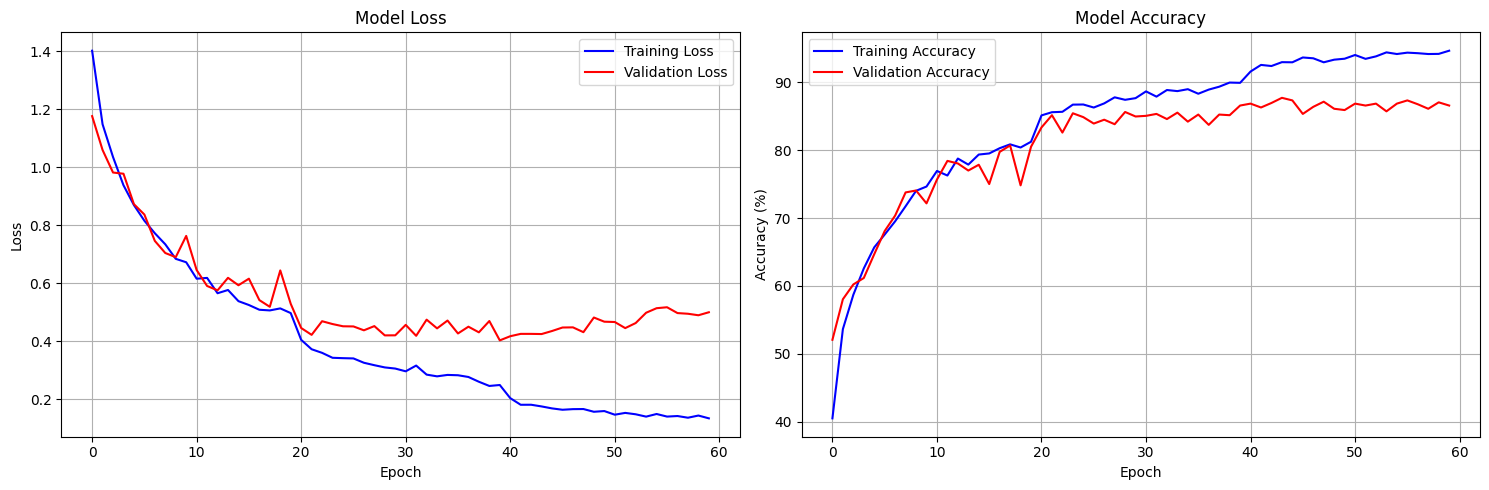

In [12]:

# Step 12: Plot Training History
print("\n=== STEP 12: Plotting Training History ===")
plot_training_history(train_losses, val_losses, train_accs, val_accs)





In [13]:
# Step 13: Evaluate on Validation Set
print("\n=== STEP 13: Validation Set Evaluation ===")
val_pred, val_true = evaluate_model(model, val_loader, device)
val_metrics = calculate_metrics(val_true, val_pred)

print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")



=== STEP 13: Validation Set Evaluation ===
Validation Metrics:
  Accuracy: 0.8655
  Precision (Macro): 0.8647
  Recall (Macro): 0.8646
  F1 Score (Macro): 0.8644
  F1 Score (Weighted): 0.8656


In [14]:
# Step 14: Evaluate on Test Set
print("\n=== STEP 14: Test Set Evaluation ===")
test_pred, test_true = evaluate_model(model, test_loader, device)
test_metrics = calculate_metrics(test_true, test_pred)

print("Test Metrics:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")




=== STEP 14: Test Set Evaluation ===
Test Metrics:
  Accuracy: 0.8362
  Precision (Macro): 0.8379
  Recall (Macro): 0.8380
  F1 Score (Macro): 0.8363
  F1 Score (Weighted): 0.8365



=== STEP 15: Plotting Confusion Matrices ===


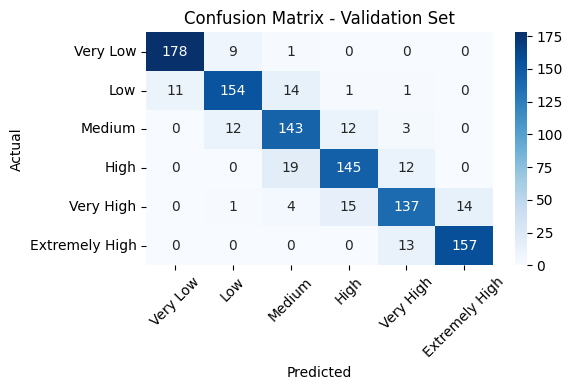

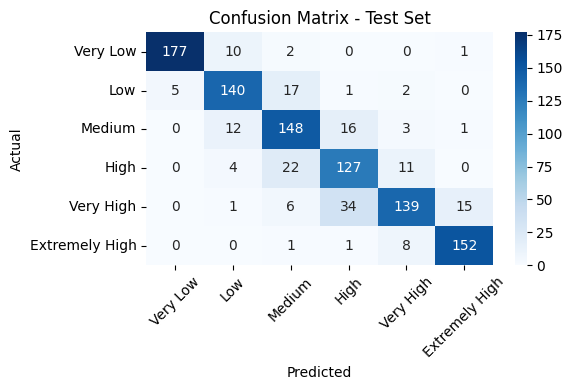

In [15]:
# Step 15: Plot Confusion Matrices
print("\n=== STEP 15: Plotting Confusion Matrices ===")
class_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']

plot_confusion_matrix(val_true, val_pred, "Validation Set", class_names)
plot_confusion_matrix(test_true, test_pred, "Test Set", class_names)



In [16]:


# Step 16: Generate Detailed Classification Reports
print("\n=== STEP 16: Detailed Classification Reports ===")
print("\nValidation Set Classification Report:")
print(classification_report(val_true, val_pred, target_names=class_names))

print("\nTest Set Classification Report:")
print(classification_report(test_true, test_pred, target_names=class_names))




=== STEP 16: Detailed Classification Reports ===

Validation Set Classification Report:
                precision    recall  f1-score   support

      Very Low       0.94      0.95      0.94       188
           Low       0.88      0.85      0.86       181
        Medium       0.79      0.84      0.81       170
          High       0.84      0.82      0.83       176
     Very High       0.83      0.80      0.81       171
Extremely High       0.92      0.92      0.92       170

      accuracy                           0.87      1056
     macro avg       0.86      0.86      0.86      1056
  weighted avg       0.87      0.87      0.87      1056


Test Set Classification Report:
                precision    recall  f1-score   support

      Very Low       0.97      0.93      0.95       190
           Low       0.84      0.85      0.84       165
        Medium       0.76      0.82      0.79       180
          High       0.71      0.77      0.74       164
     Very High       0.85      0.7

In [17]:



# Step 17: Final Results Summary
print("\n=== STEP 17: Final Results Summary ===")
results_df = pd.DataFrame({
    'Dataset': ['Validation', 'Test'],
    'Accuracy': [val_metrics['Accuracy'], test_metrics['Accuracy']],
    'Precision (Macro)': [val_metrics['Precision (Macro)'], test_metrics['Precision (Macro)']],
    'Recall (Macro)': [val_metrics['Recall (Macro)'], test_metrics['Recall (Macro)']],
    'F1 Score (Macro)': [val_metrics['F1 Score (Macro)'], test_metrics['F1 Score (Macro)']],
    'F1 Score (Weighted)': [val_metrics['F1 Score (Weighted)'], test_metrics['F1 Score (Weighted)']]
})

print(results_df.round(4).to_string(index=False))

print(f"\nSextile Thresholds Used:")
print(f"Very Low: ≤{sextiles[0]:.2f}")
print(f"Low: {sextiles[0]:.2f} - {sextiles[1]:.2f}")
print(f"Medium: {sextiles[1]:.2f} - {sextiles[2]:.2f}")
print(f"High: {sextiles[2]:.2f} - {sextiles[3]:.2f}")
print(f"Very High: {sextiles[3]:.2f} - {sextiles[4]:.2f}")
print(f"Extremely High: >{sextiles[4]:.2f}")




=== STEP 17: Final Results Summary ===
   Dataset  Accuracy  Precision (Macro)  Recall (Macro)  F1 Score (Macro)  F1 Score (Weighted)
Validation    0.8655             0.8647          0.8646            0.8644               0.8656
      Test    0.8362             0.8379          0.8380            0.8363               0.8365

Sextile Thresholds Used:
Very Low: ≤417.00
Low: 417.00 - 996.51
Medium: 996.51 - 2027.00
High: 2027.00 - 3717.49
Very High: 3717.49 - 7522.30
Extremely High: >7522.30


In [18]:


# Step 18: Save Important Variables
print("\n=== STEP 18: Training Complete ===")
print("Model trained successfully!")
print("All metrics calculated and plots generated.")
print(f"Model now classifies production into 6 categories: {class_names}")
print("\nImportant variables saved:")
print("- model: The trained F1-Transformer model")
print("- scaler: The fitted StandardScaler for preprocessing")
print("- sextiles: The sextiles used for 6-class label creation")


=== STEP 18: Training Complete ===
Model trained successfully!
All metrics calculated and plots generated.
Model now classifies production into 6 categories: ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']

Important variables saved:
- model: The trained F1-Transformer model
- scaler: The fitted StandardScaler for preprocessing
- sextiles: The sextiles used for 6-class label creation
